In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 91.0 MB/s eta 0:00:000m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 MB 73.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]━━━ 1/2 [xgboost]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_csv('./PJME_hourly.csv')

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

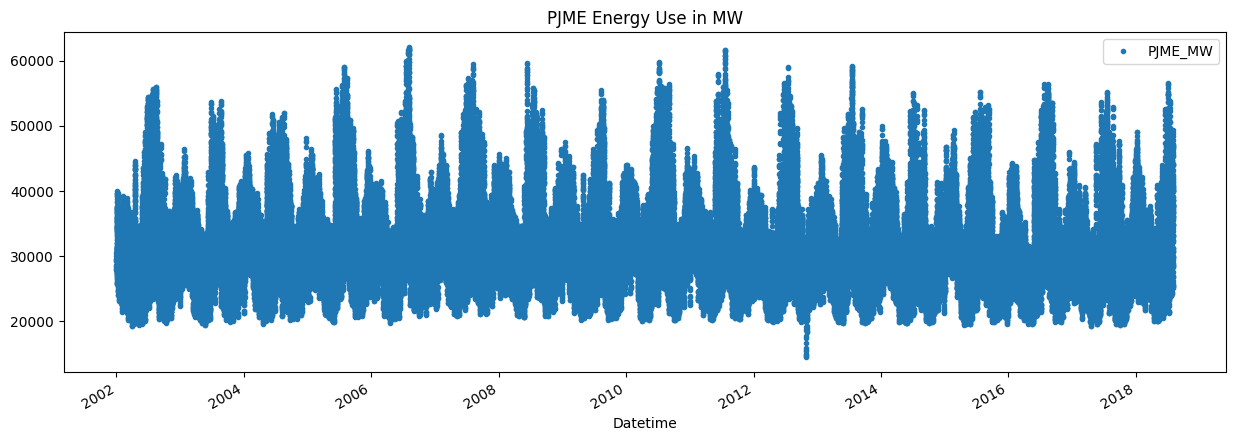

In [6]:
color_pal = sns.color_palette()

df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

In [7]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

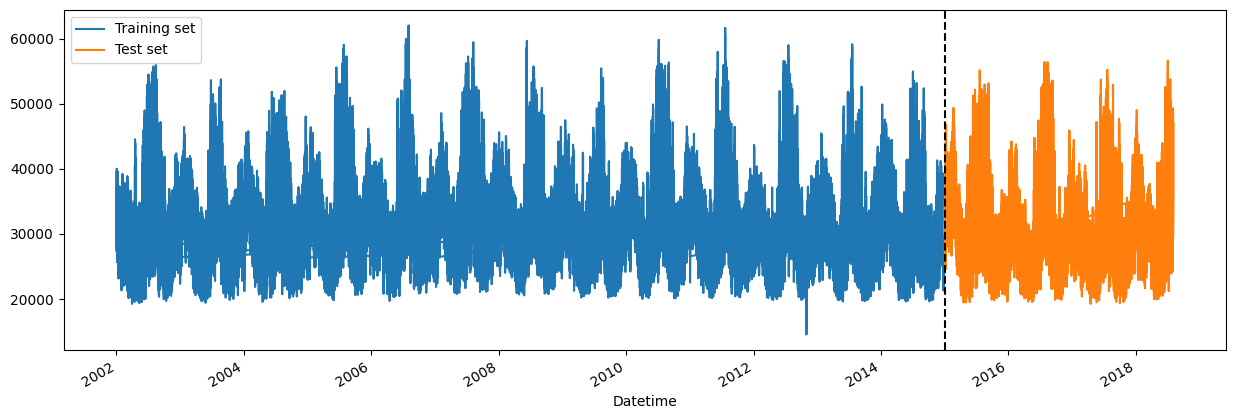

In [8]:
#train test split
train = df.loc[df.index<'01-01-2015']
test = df.loc[df.index>='01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax = ax, label = 'train')
test.plot(ax = ax, label = 'test')
ax.axvline('01-01-2015', color = 'black', ls = '--')
ax.legend(['Training set','Test set'])

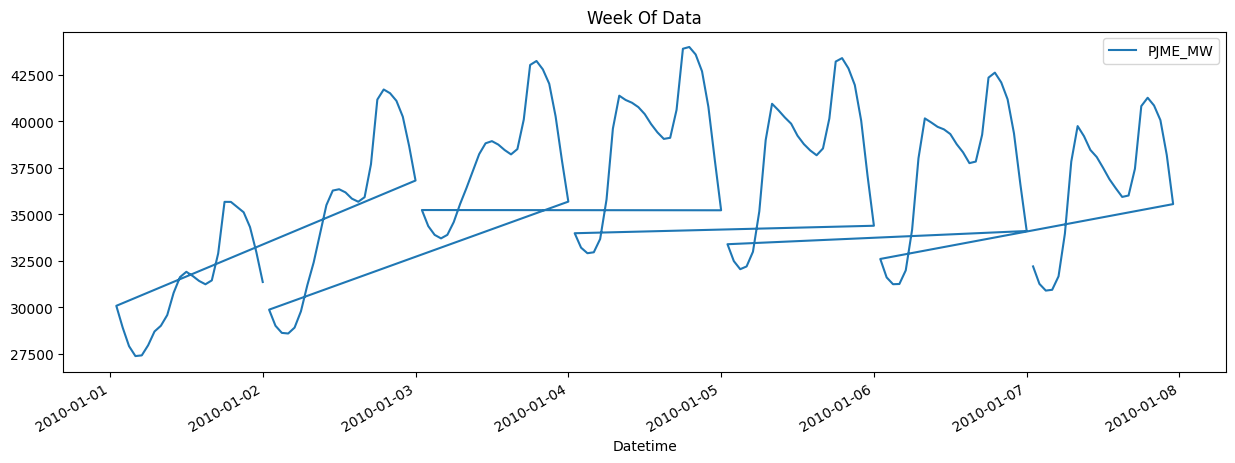

In [9]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [25]:
#feature creation

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

Text(0.5, 1.0, 'MW by hour')

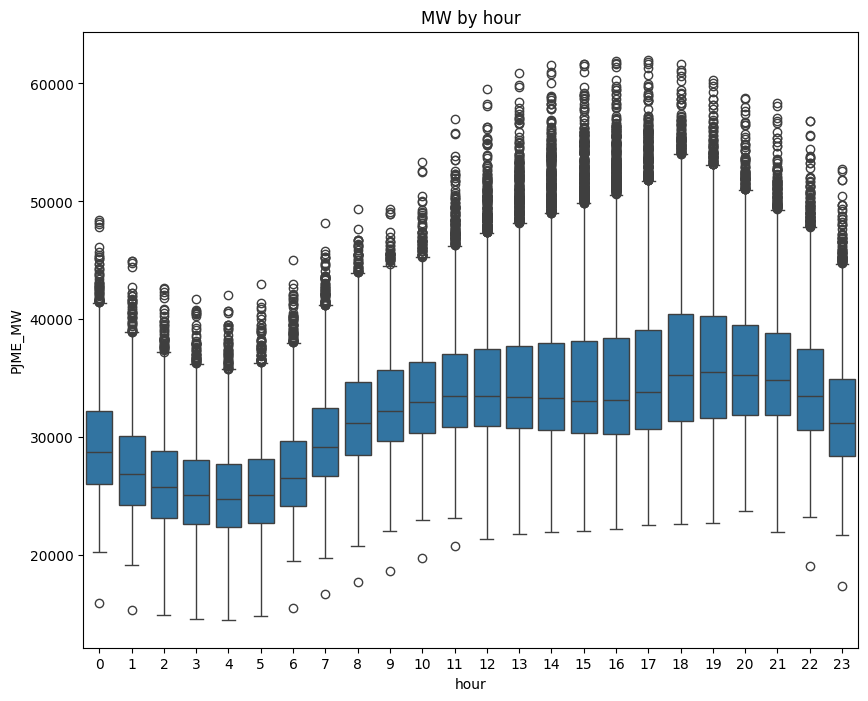

In [19]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(df, x = 'hour', y = 'PJME_MW', palette )
ax.set_title('MW by hour')

In [26]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [28]:
reg = xgb.XGBRegressor(n_estimators = 1000, objective = 'reg:linear', max_depth = 3,learning_rate = 0.01, early_stopping_rounds = 50, booster = 'gbtree', base_score = 0.5)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train),(X_test, y_test)], verbose = 100)

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:38:04] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[988]	validation_0-rmse:3060.25324	validation_1-rmse:3728.07396


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


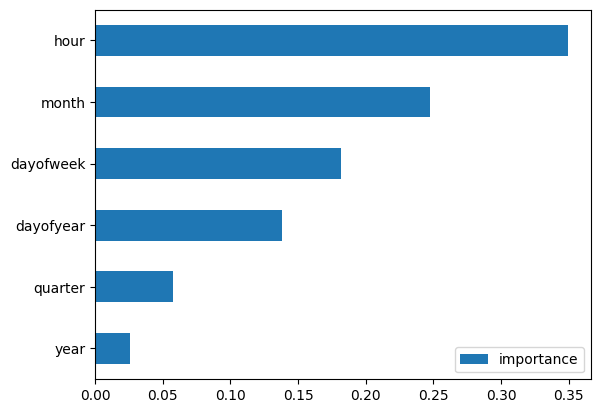

In [31]:
fi = pd.DataFrame(data = reg.feature_importances_, index = reg.feature_names_in_, columns = ['importance'])

fi.sort_values('importance').plot(kind = 'barh')
plt.show()

In [33]:
test['prediction'] = reg.predict(X_test)

df= df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

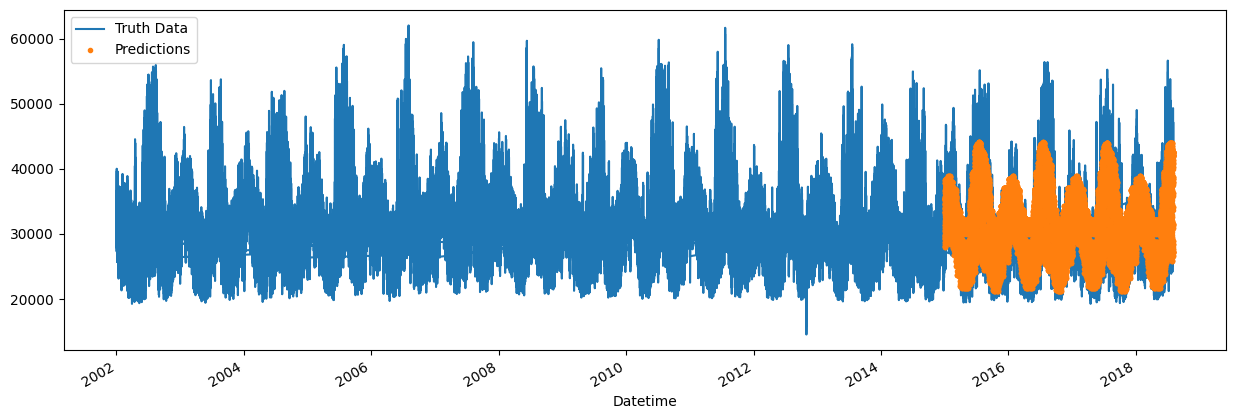

In [37]:
ax = df[['PJME_MW']].plot(figsize = (15,5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data','Predictions'])


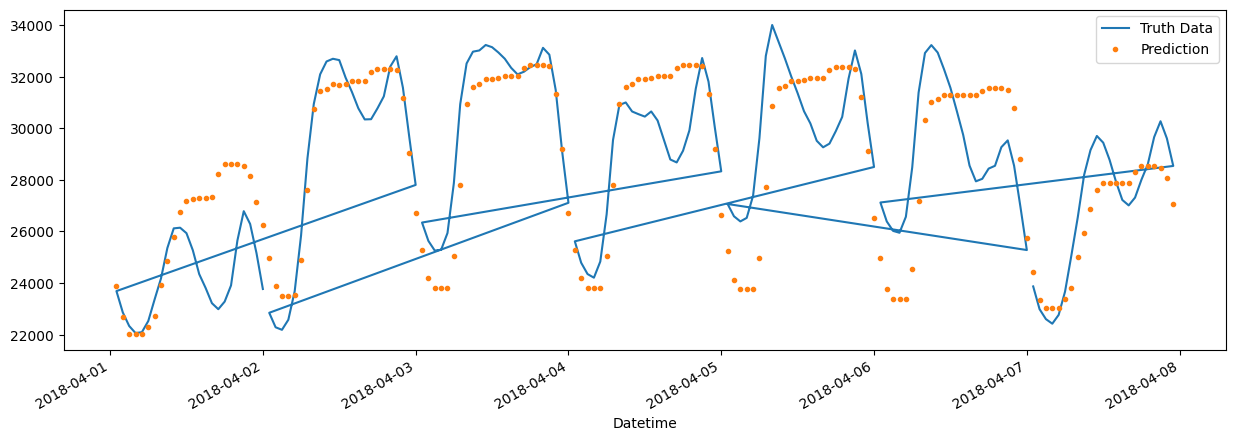

In [43]:
ax = df.loc[(df.index >'04-01-2018')&(df.index<'04-08-2018')]['PJME_MW'].plot(figsize = (15, 5))

df.loc[(df.index >'04-01-2018')&(df.index<'04-08-2018')]['prediction'].plot(style = '.')

plt.legend(['Truth Data','Prediction'])

In [47]:
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))


In [48]:
test['error'] = test['PJME_MW'] - test['prediction']

In [51]:
test['date'] = test.index.date

In [54]:
test.groupby(['date'])['error'].mean().sort_values(ascending = False)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
                  ...     
2017-06-08    -7133.564941
2017-05-29    -7309.812256
2017-09-04    -7314.036458
2015-12-25    -7655.966553
2016-07-04    -9057.563395
Name: error, Length: 1311, dtype: float64